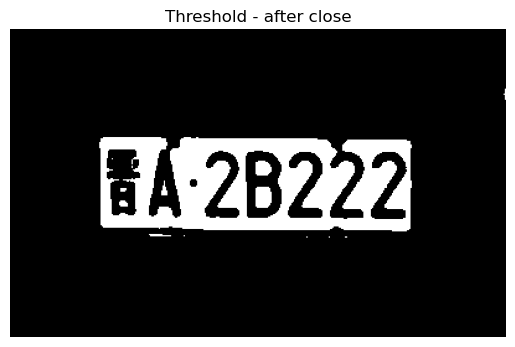

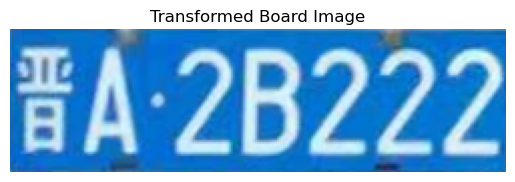

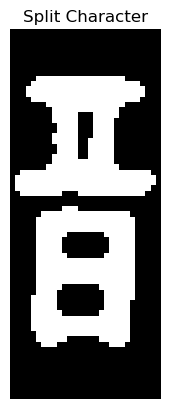

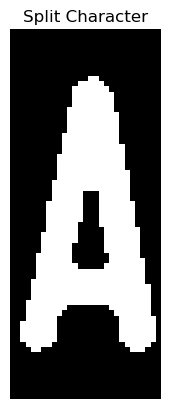

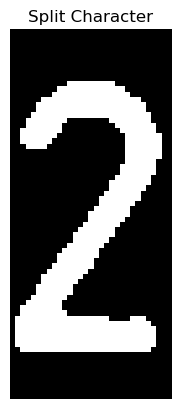

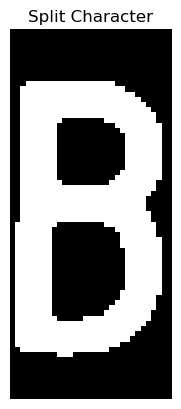

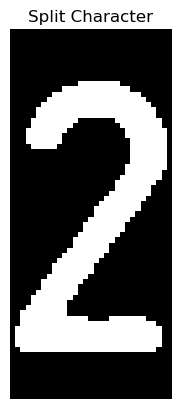

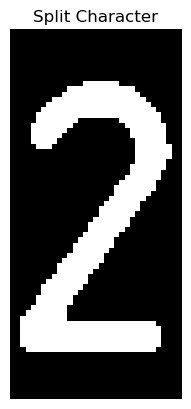

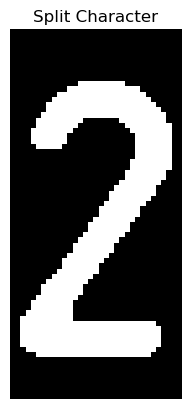

识别结果: 晋A2B222


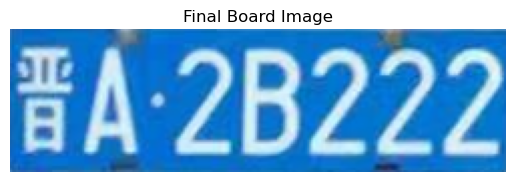

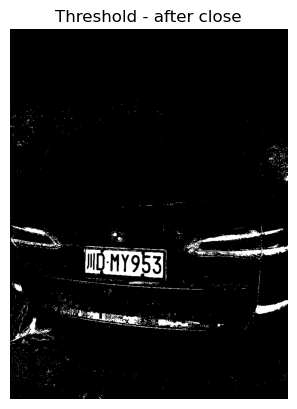

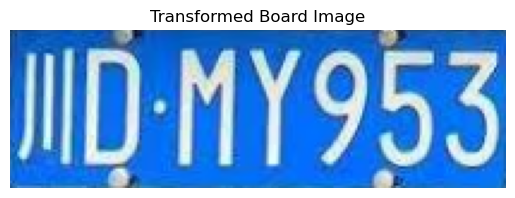

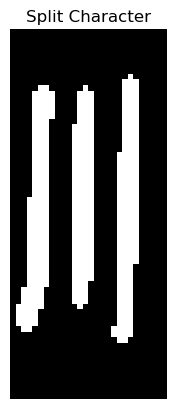

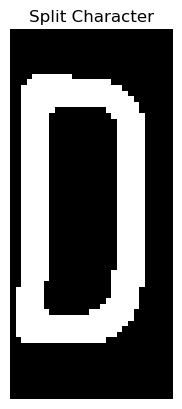

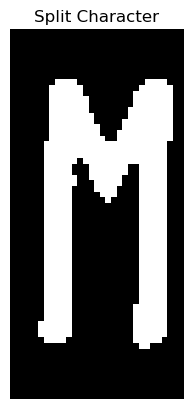

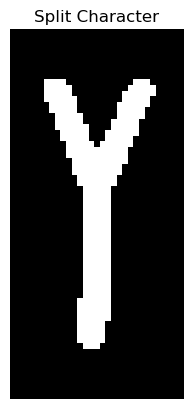

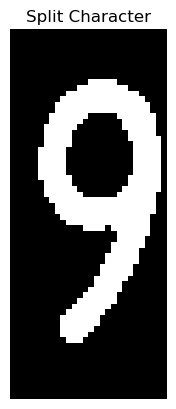

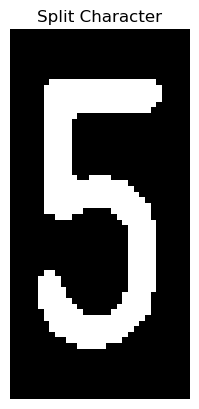

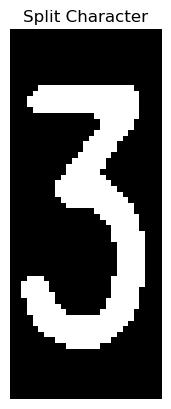

识别结果: 川DMY953


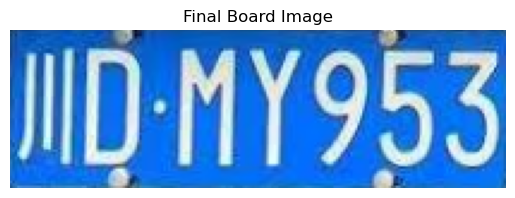

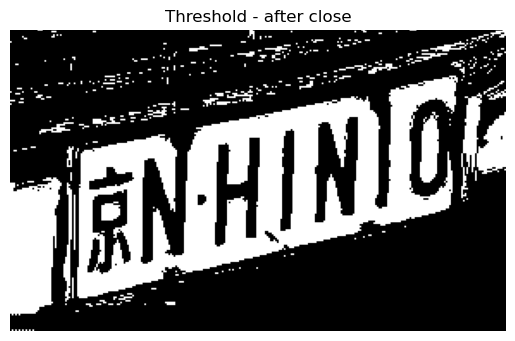

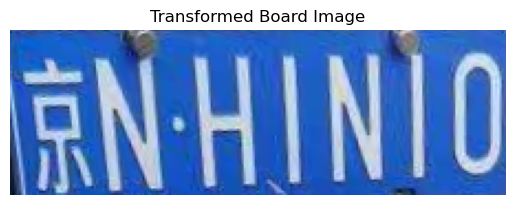

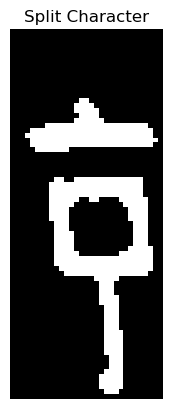

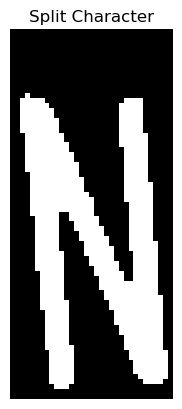

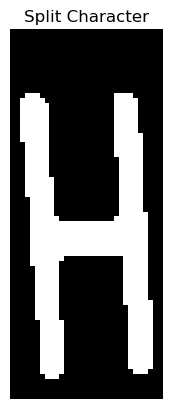

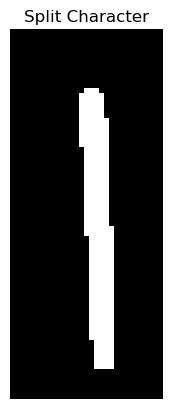

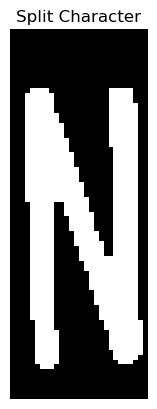

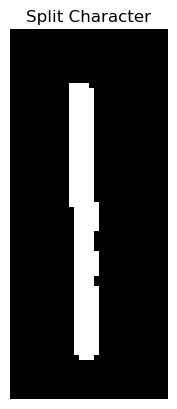

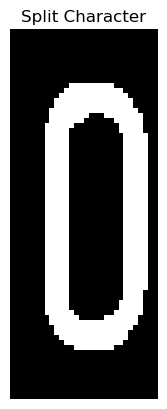

识别结果: 京NH1N10


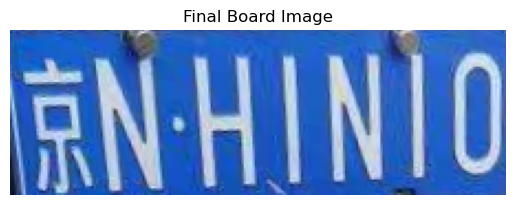

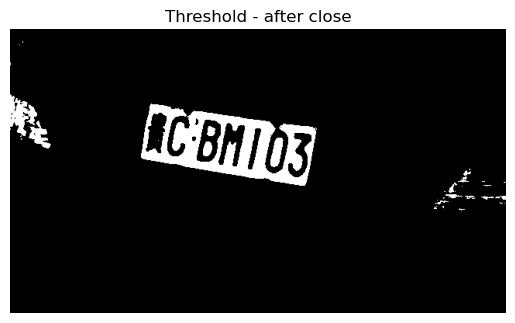

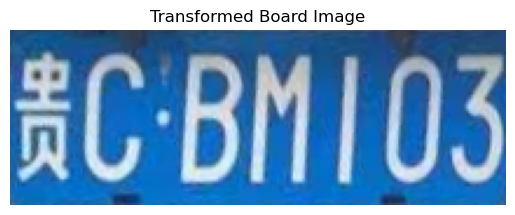

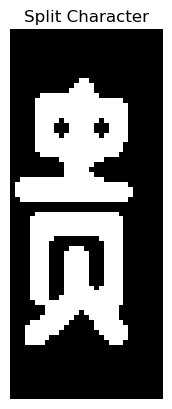

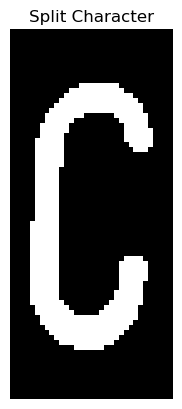

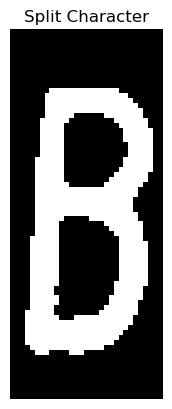

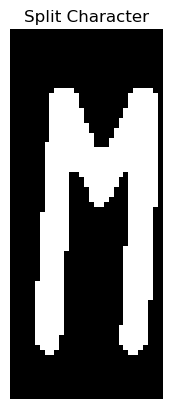

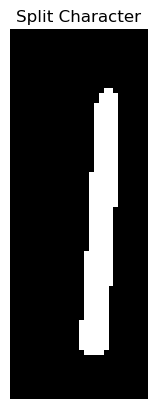

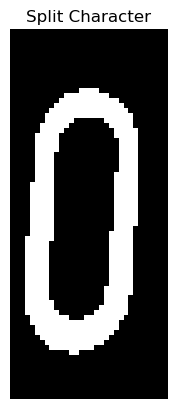

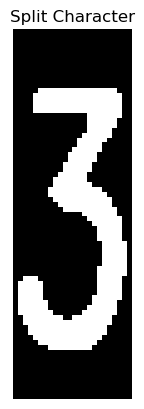

识别结果: 贵CBM103


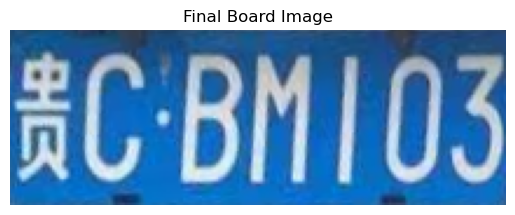

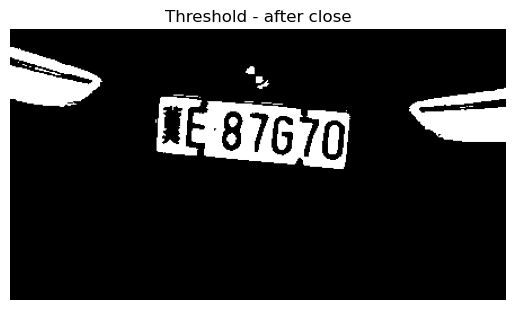

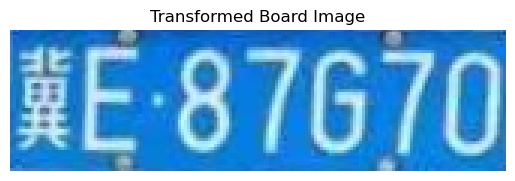

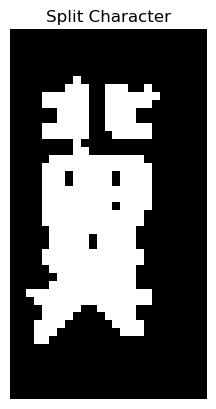

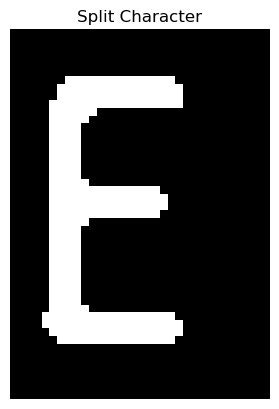

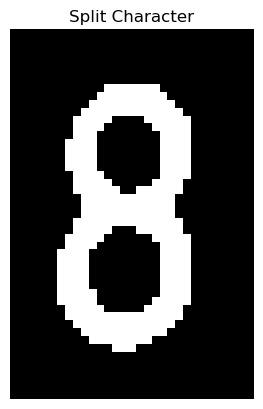

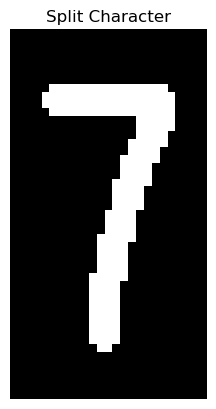

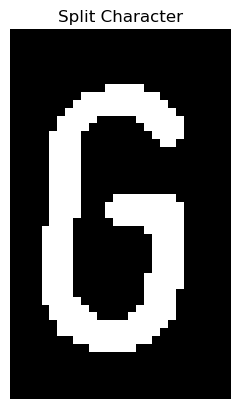

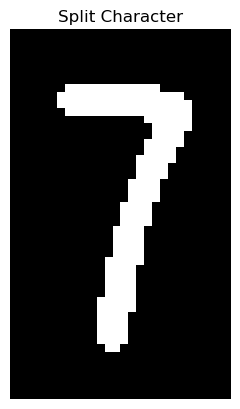

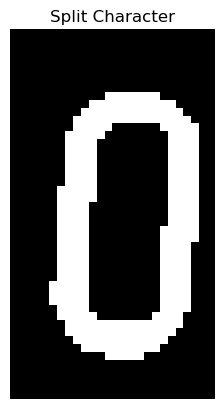

识别结果: 冀E87G70


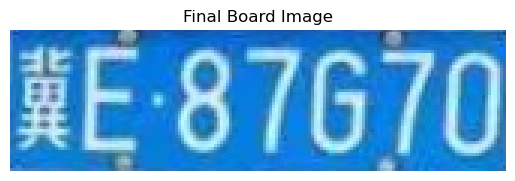

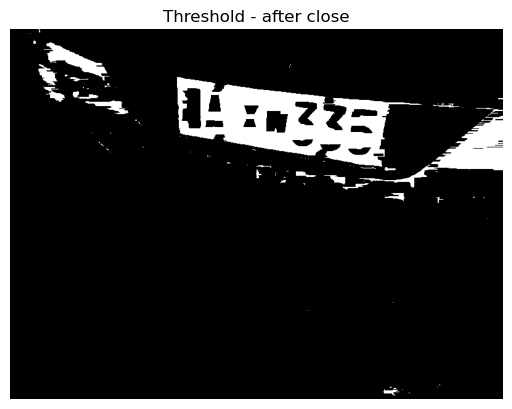

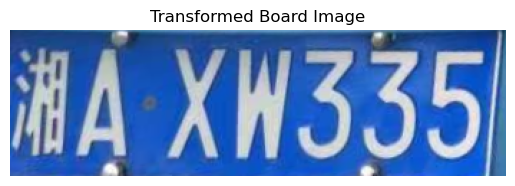

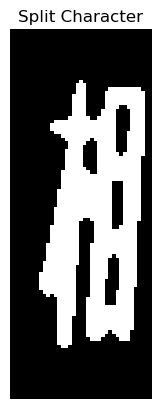

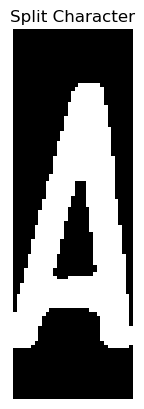

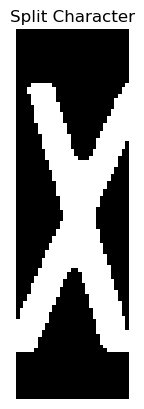

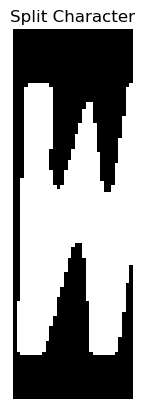

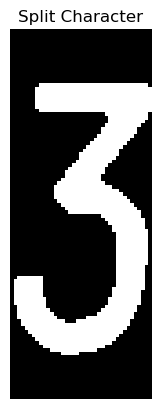

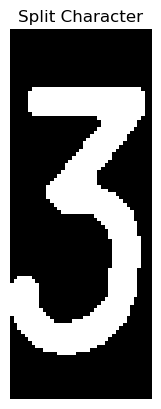

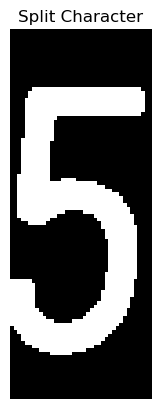

识别结果: 湘AXW335


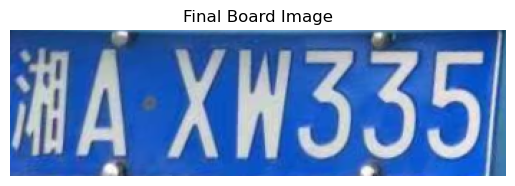

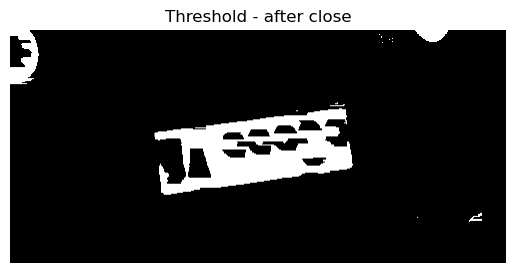

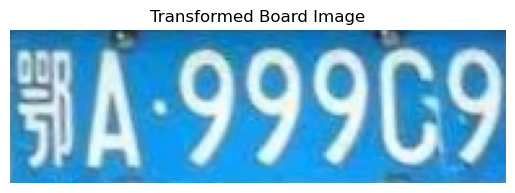

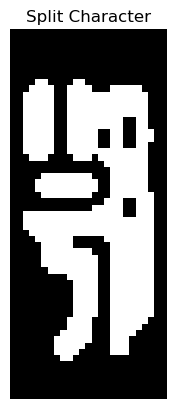

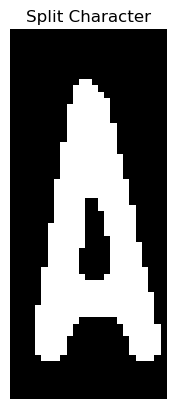

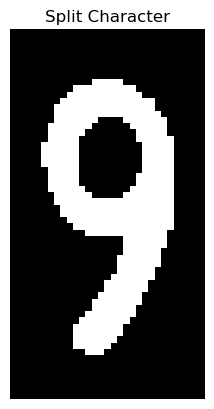

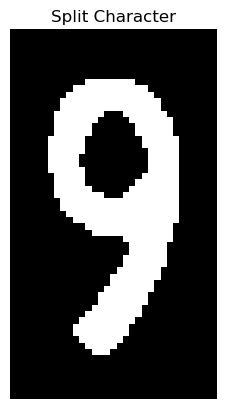

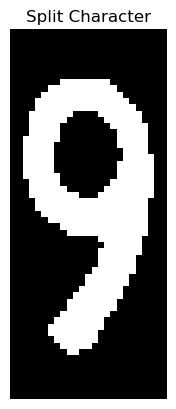

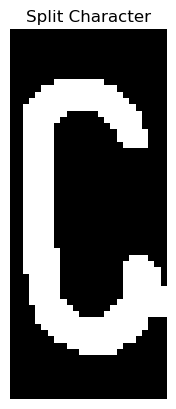

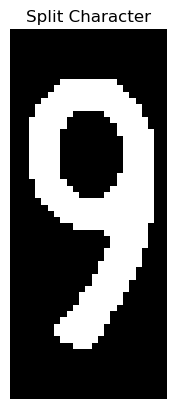

识别结果: 鄂A999C9


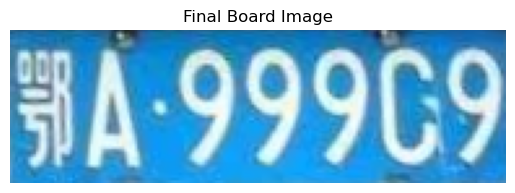

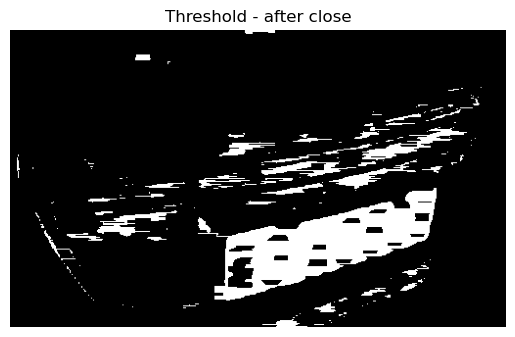

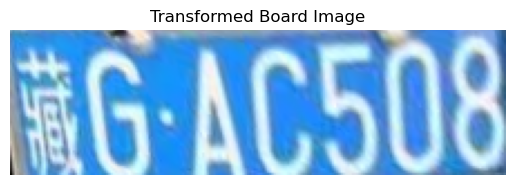

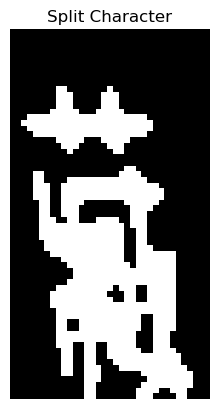

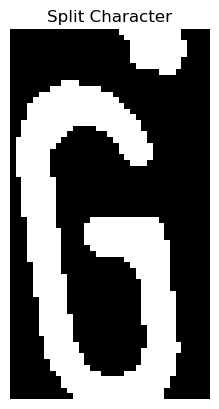

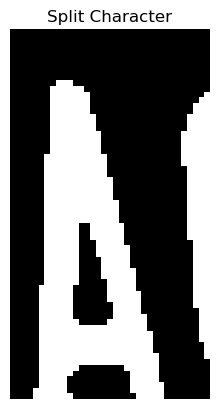

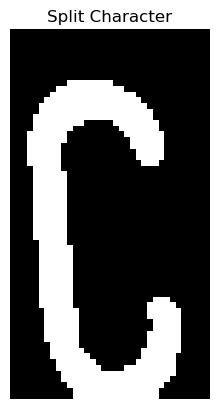

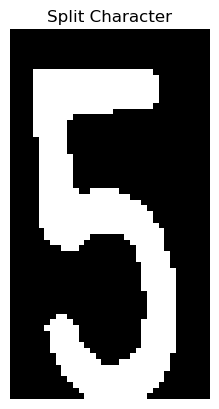

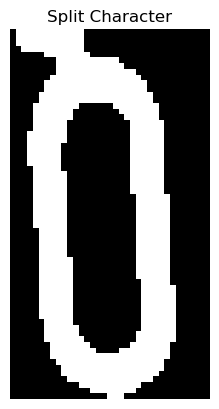

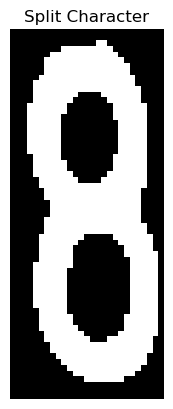

识别结果: 藏GAC508


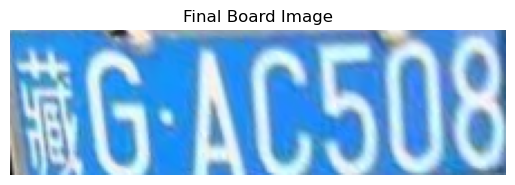

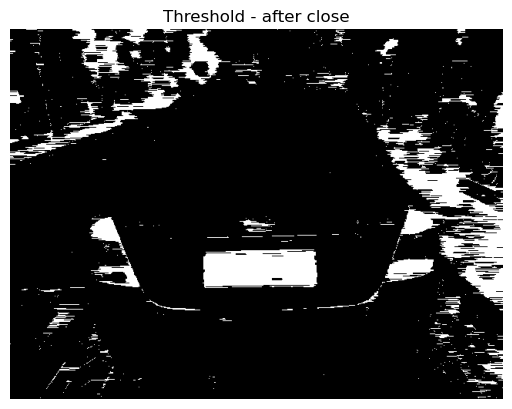

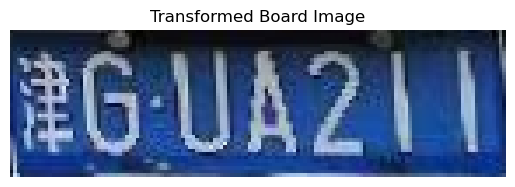

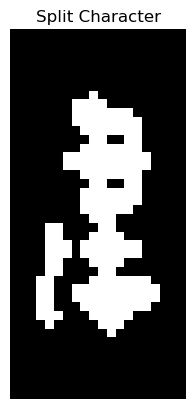

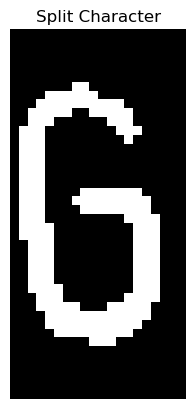

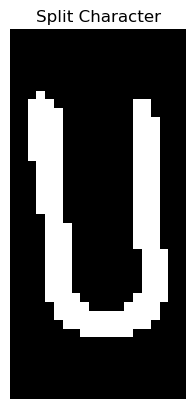

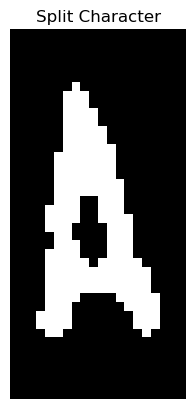

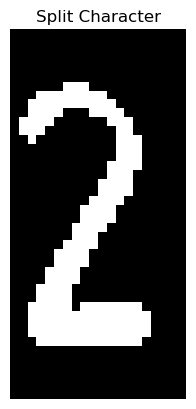

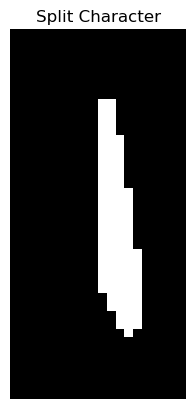

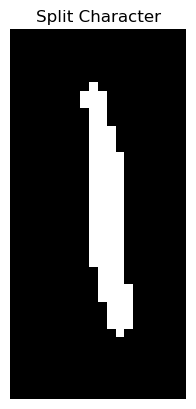

识别结果: 津GUA211


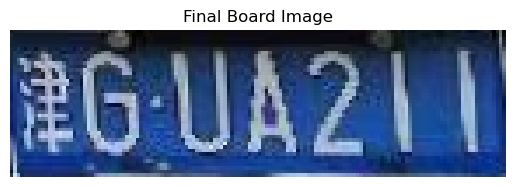

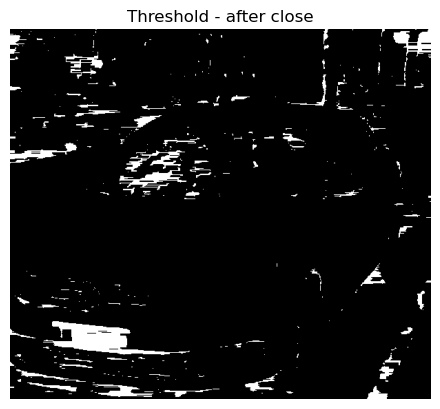

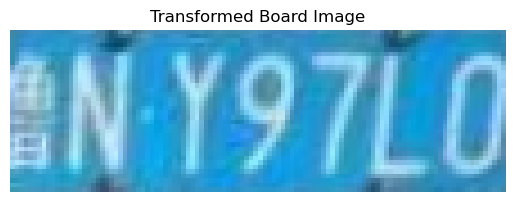

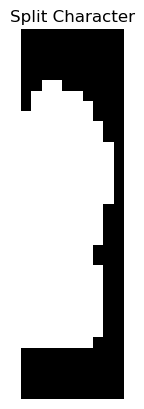

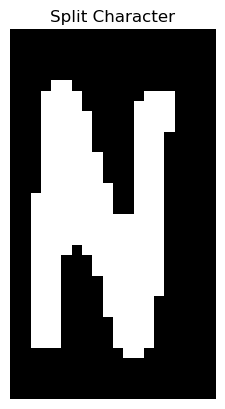

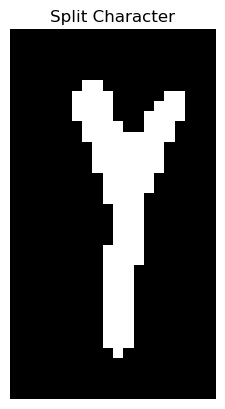

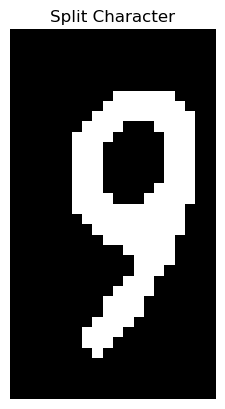

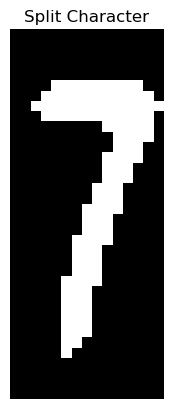

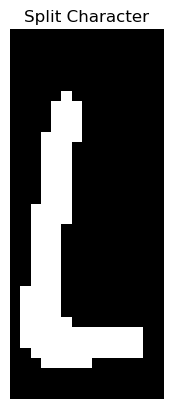

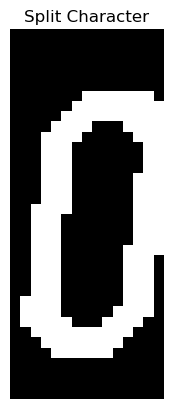

识别结果: 鲁NY97L0


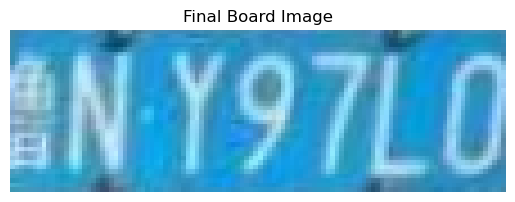

array([[[167, 135,  64],
        [173, 134,  60],
        [182, 135,  59],
        ...,
        [173, 136,  56],
        [175, 136,  62],
        [175, 136,  67]],

       [[171, 136,  60],
        [179, 135,  53],
        [189, 135,  49],
        ...,
        [178, 137,  42],
        [174, 130,  42],
        [177, 134,  53]],

       [[174, 139,  55],
        [183, 138,  50],
        [200, 142,  51],
        ...,
        [181, 137,  34],
        [180, 135,  40],
        [183, 138,  50]],

       ...,

       [[181, 148,  44],
        [186, 151,  44],
        [192, 155,  47],
        ...,
        [188, 139,  48],
        [191, 140,  48],
        [184, 139,  55]],

       [[203, 172,  70],
        [202, 170,  66],
        [201, 166,  62],
        ...,
        [187, 141,  52],
        [188, 143,  52],
        [179, 138,  60]],

       [[178, 151,  60],
        [183, 152,  61],
        [184, 154,  63],
        ...,
        [186, 146,  65],
        [182, 143,  60],
        [166, 133,  64]]

In [2]:
import os
import re
import shutil
import numpy as np
import cv2
import matplotlib.pyplot as plt

# 定义 HSV 颜色阈值区间类，用于蓝色/绿色车牌区域提取
class ColorThreshold:
    def __init__(self, h_bounds, s_bounds, v_bounds):
        self.min_val = np.array([h_bounds[0], s_bounds[0], v_bounds[0]])
        self.max_val = np.array([h_bounds[1], s_bounds[1], v_bounds[1]])

    def bounds(self):
        return self.min_val, self.max_val

# 使用 matplotlib 显示图像，支持灰度和彩色
def display_image(label, image):
    plt.figure()
    if image.ndim == 2:
        plt.imshow(image, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(label)
    plt.axis('off')
    plt.show()

# 加载字符模板图像（每类字符多个样本）
def prepare_templates(directory='video_template/video_template'):
    temp_file = 'temp.bmp'
    output = {folder: [] for folder in os.listdir(directory)}

    for root, _, files in os.walk(directory):
        category = os.path.basename(root)
        for filename in files:
            src = os.path.join(root, filename)
            shutil.copy(src, temp_file)
            img = cv2.imread(temp_file, cv2.IMREAD_GRAYSCALE)
            _, bw = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
            filtered = cv2.medianBlur(bw, 3)
            output[category].append(filtered)
    os.remove(temp_file)
    return output

# 对四边形顶点进行排序：左上、右上、右下、左下
def sort_corners(points):
    ordered = np.zeros((4, 2), dtype='float32')
    s = points.sum(axis=1)
    d = np.diff(points, axis=1)
    ordered[0], ordered[2] = points[np.argmin(s)], points[np.argmax(s)]
    ordered[1], ordered[3] = points[np.argmin(d)], points[np.argmax(d)]
    return ordered

# 透视变换提取矩形区域
def rectify_region(image, corners):
    coords = sort_corners(corners)
    (tl, tr, br, bl) = coords
    width = int(max(np.linalg.norm(br - bl), np.linalg.norm(tr - tl)))
    height = int(max(np.linalg.norm(tr - br), np.linalg.norm(tl - bl)))
    destination = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype='float32')
    matrix = cv2.getPerspectiveTransform(coords, destination)
    return cv2.warpPerspective(image, matrix, (width, height))

# 提取车牌区域：HSV 分割 + 形态学处理 + 最大轮廓透视提取
def extract_plate_area(frame, color_range, extended=False):
    hsv_img = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    lower, upper = color_range.bounds()
    mask = cv2.inRange(hsv_img, lower, upper)
    inverted = cv2.bitwise_not(mask)

    if extended:
        pattern = np.array([[0]*5, [1]*5, [0]*5], dtype=np.uint8)
        inverted = cv2.morphologyEx(inverted, cv2.MORPH_CLOSE, pattern, iterations=3)

    morph_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    for method in [cv2.MORPH_OPEN, cv2.MORPH_CLOSE, cv2.MORPH_OPEN]:
        inverted = cv2.morphologyEx(inverted, method, morph_kernel, iterations=3)

    regions, _ = cv2.findContours(inverted, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    primary = max(regions, key=cv2.contourArea)
    points = cv2.approxPolyDP(primary, 0.02 * cv2.arcLength(primary, True), True).reshape(-1, 2)
    cropped = rectify_region(frame, points)
    display_image('Plate Extracted', cropped)
    return cropped

# 保留大于最小比例的轮廓区域（去除小噪声）
def trim_noise(gray_img, min_ratio):
    total = gray_img.shape[0] * gray_img.shape[1]
    boundary = total * min_ratio
    cleared = np.zeros_like(gray_img)
    outlines, _ = cv2.findContours(gray_img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    for outline in outlines:
        if cv2.contourArea(outline) >= boundary:
            cv2.drawContours(cleared, [outline], -1, 255, thickness=cv2.FILLED)
    return cv2.bitwise_and(gray_img, cleared)

# 对车牌图像分割字符子图像
def isolate_characters(cropped_img, x_coords, widths, min_part=0.05):
    gray = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    binary = cv2.medianBlur(binary, 3)
    segments = []
    for x, w in zip(x_coords, widths):
        roi = binary[:, x:x+w]
        cleaned = trim_noise(roi, min_part)
        display_image('Char Slice', cleaned)
        segments.append(cleaned)
    return segments

# 匹配单个字符图像到模板字典中，返回匹配分最高的字符
def character_match(single_char, database, pos=0):
    highest, symbol = -1, None
    for label, items in database.items():
        if (pos == 0 and not re.search(r'[\u4e00-\u9fa5]', label)) or (pos > 0 and re.search(r'[\u4e00-\u9fa5]', label)):
            continue
        for sample in items:
            scaled = cv2.resize(sample, (single_char.shape[1], single_char.shape[0]))
            score = cv2.matchTemplate(single_char, scaled, cv2.TM_CCOEFF_NORMED).max()
            if score > highest:
                highest, symbol = score, label
    return symbol.upper() if symbol else '?'

# 完整的车牌识别流程封装：输入图像 → HSV提取 → 分割字符 → 模板识别
def process_license(image, color_mask, char_x, char_widths, min_fill=0.05, enhance=False):
    target = extract_plate_area(image, color_mask, enhance)
    parts = isolate_characters(target, char_x, char_widths, min_fill)
    reference = prepare_templates()
    decoded = ''.join(character_match(part, reference, i) for i, part in enumerate(parts))
    print('识别结果:', decoded)
    return decoded

# 测试识别 10 张图片
if __name__ == '__main__':
    # 每张图可能使用不同的 HSV 区间和字符切割参数
    test_cases = [
        (ColorThreshold((0, 179), (0, 150), (0, 250)), 'car1.jpg', [5, 36, 84, 117, 151, 183, 216], [30, 28, 32, 30, 30, 34, 32]),
        (ColorThreshold((0, 178), (0, 147), (0, 253)), 'car2.jpg', [4, 29, 63, 94, 121, 148, 182], [27, 30, 30, 30, 27, 31, 32]),
        (ColorThreshold((0, 180), (0, 158), (0, 252)), 'car3.jpg', [4, 38, 83, 112, 144, 172, 197], [30, 32, 30, 30, 29, 31, 32]),
        (ColorThreshold((0, 177), (0, 148), (0, 251)), 'car4.jpg', [2, 29, 71, 100, 127, 159, 189], [30, 32, 30, 30, 29, 31, 32]),
        (ColorThreshold((0, 179), (0, 150), (0, 254)), 'car5.jpg', [2, 22, 51, 76, 97, 119, 140], [26, 32, 30, 26, 27, 27, 32]),
        (ColorThreshold((0, 181), (0, 165), (0, 255)), 'car6.jpg', [2, 47, 112, 158, 202, 249, 294], [38, 34, 30, 34, 38, 38, 38]),
        (ColorThreshold((0, 180), (0, 162), (0, 253)), 'car7.jpg', [2, 27, 61, 86, 114, 142, 167], [24, 26, 30, 32, 26, 26, 26]),
        (ColorThreshold((0, 180), (0, 96), (0, 252)), 'car8.jpg', [2, 34, 77, 106, 134, 164, 194], [34, 34, 34, 34, 34, 34, 34]),
        (ColorThreshold((0, 180), (0, 94), (0, 250)), 'car9.jpg', [2, 21, 46, 66, 86, 101, 122], [19, 19, 19, 19, 19, 19, 19]),
        (ColorThreshold((0, 179), (0, 150), (0, 253)), 'car10.jpg', [2, 12, 31, 46, 66, 80, 96], [11, 19, 19, 19, 16, 16, 19])
    ]

    for idx, (hsv_def, fname, xlist, wlist) in enumerate(test_cases):
        img = cv2.imread(fname)
        process_license(img, hsv_def, xlist, wlist, min_fill=0.005, enhance=True if idx >= 5 else False)


In [3]:
import os
import random
import re
import shutil
import time

import cv2
import numpy as np

from PIL import ImageFont, ImageDraw, Image

show_flag = False

# 指定字体路径（请根据操作系统调整路径）
font_path = "C:/Windows/Fonts/simhei.ttf"  # Windows 黑体
font_pil = ImageFont.truetype(font_path, 36)


def cv_show(win_name, img, origin_img=None, size=(900, 600)):
    """显示图像，可选定尺寸，窗口等待键盘输入后关闭"""
    if origin_img is None:
        img_resized = cv2.resize(img, size)
        cv2.imshow(win_name, img_resized)
        cv2.waitKey(1)
    else:
        overlay = origin_img.copy()
        overlay[img == 255] = (0, 255, 0)
        img = cv2.addWeighted(overlay, 0.7, origin_img, 0.3, 0)
        img_resized = cv2.resize(img, size)
        cv2.imshow(win_name, img_resized)
        cv2.waitKey(1)


def init_template_dict():
    template_filedir = 'video_template/video_template'
    temp_path = 'temp.bmp'
    template_dict = {key: [] for key in os.listdir(template_filedir)}
    for root, dirs, files in os.walk(template_filedir):
        key = os.path.basename(root)
        for file in files:
            image_path = os.path.join(root, file)
            shutil.copy(image_path, temp_path)
            temp_image = cv2.imread(temp_path)
            temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2GRAY)
            _, thresh = cv2.threshold(temp_image, 127, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
            thresh = cv2.medianBlur(thresh, 3)
            template_dict[key].append(thresh)
    os.remove(temp_path)
    return template_dict


class HSVDict:
    def __init__(self, low_h, high_h, low_s, high_s, low_v, high_v):
        self.low_h = low_h
        self.high_h = high_h
        self.low_s = low_s
        self.high_s = high_s
        self.low_v = low_v
        self.high_v = high_v
        self.lower = np.array([self.low_h, self.low_s, self.low_v])
        self.higher = np.array([self.high_h, self.high_s, self.high_v])

    def get_lower_range(self):
        return self.lower

    def get_higher_range(self):
        return self.higher


SOBEL_TEMPLATE = [
    np.array([-2, -1, 0, -1, 0, 1, 0, 1, 2]).reshape(3, 3),
    np.array([0, 1, 2, -1, 0, 1, -2, -1, 0]).reshape(3, 3),
    np.array([1, 2, 1, 0, 0, 0, -1, -2, -1]).reshape(3, 3),
    np.array([2, 1, 0, 1, 0, -1, 0, -1, -2]).reshape(3, 3),
    np.array([1, 0, -1, 2, 0, -2, 1, 0, -1]).reshape(3, 3),
    np.array([0, -1, -2, 1, 0, -1, 2, 1, 0]).reshape(3, 3),
    np.array([-1, -2, -1, 0, 0, 0, 1, 2, 1]).reshape(3, 3),
    np.array([-1, 0, 1, -2, 0, 2, -1, 0, 1]).reshape(3, 3)
]


def extended_sobel(gray_frame):
    result_frame = np.zeros_like(gray_frame)
    for sobel_operator in SOBEL_TEMPLATE:
        filtered = cv2.filter2D(gray_frame, cv2.CV_32F, sobel_operator)
        result_frame = np.maximum(result_frame, np.abs(filtered))
    result_frame = cv2.normalize(result_frame, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    return result_frame


blue = [
    np.array([0, 0, 0]),
    np.array([180, 159, 256])
]


def order_points(pts):
    '''对4点进行排序，下标0、1、2、3分别是左上、右上、右下、左下'''
    rect = np.zeros((4, 2), dtype="float32")
    s = pts.sum(axis=1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis=1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect


def perspectiveTransform(pntsOrded, img):
    tl, tr, br, bl = pntsOrded

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype="float32")

    M = cv2.getPerspectiveTransform(pntsOrded, dst)
    warped = cv2.warpPerspective(img, M, (maxWidth, maxHeight))
    return warped


def get_contours(gray_image):
    contours, _ = cv2.findContours(gray_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    return contours


def get_contour_by_ratio(gray_image: np.ndarray, ratio=0.4):
    height, width = gray_image.shape[:2]
    area = height * width
    result = list()
    contours = get_contours(gray_image)
    for contour in contours:
        contour_ratio = cv2.contourArea(contour) / area
        if contour_ratio < ratio:
            break
        result.append(contour)
    return result


def mask_image_by_contour_ratio(gray_image, ratio):
    mask_contour = get_contour_by_ratio(gray_image, ratio)
    mask = np.zeros_like(gray_image)
    cv2.drawContours(mask, mask_contour, -1, 255, thickness=cv2.FILLED)
    result_image = cv2.bitwise_and(mask, gray_image)
    return result_image


def include_chinese(string: str):
    pattern = re.compile(r'[\u4e00-\u9fa5+]')
    match = pattern.search(string)
    return match is not None


def match_character(char_img, templates, location=0):
    """
    使用模板匹配对单个字符图像进行识别。
    遍历所有模板，选择匹配得分最高的字符。
    """
    best_match = None
    best_score = -1
    for index, (char, t_list) in enumerate(templates.items()):
        # 按位置过滤中英文模板
        if location == 0:
            if not include_chinese(char):
                continue
        else:
            if include_chinese(char):
                continue

        for t in t_list:
            w = char_img.shape[1]
            h = char_img.shape[0]
            # 将模板尺寸调整为与候选字符图像一致
            resized_t = cv2.resize(t, (w, h))
            # 这里只给了一个角度遍历示例，如有需要可加大角度范围或更精细
            for angle in range(0, 1, 5):
                M = cv2.getRotationMatrix2D((w // 2, h // 2), angle, 1.0)
                templateR = cv2.warpAffine(resized_t, M, (w, h))

                result = cv2.matchTemplate(char_img, templateR, cv2.TM_CCOEFF_NORMED)
                score = result.max()
                if score > best_score:
                    best_score = score
                    best_match = char
    return best_match, best_score


# 初始化模板字典
template_dict = init_template_dict()


def put_chinese_text(img, text, position, font, color=(0, 255, 0)):
    """
    使用 PIL 在图像上绘制中文字符。
    注意：输入的 img 为 BGR 格式，内部进行 RGB/BGR 转换
    """
    # 将 OpenCV 的 BGR 图像转为 PIL 的 RGB 图像
    img_pil = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    draw = ImageDraw.Draw(img_pil)
    # 绘制文本，注意 fill 的颜色为 RGB 格式
    draw.text(position, text, font=font, fill=color)
    # 转回 OpenCV 的 BGR 格式
    img = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
    return img


def process_frame(frame):
    """
    对单帧图像进行处理。
    这里除了识别以外，为了可视化，还会对检测到的车牌区域在原图上画一个红色外接矩形，
    并返回这张“处理后”的帧用于保存到视频中。
    """
    # === 1. 常规预处理 ===
    frame_blur = cv2.GaussianBlur(frame, (3, 3), 0)
    hsv_frame = cv2.cvtColor(frame_blur, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv_frame, blue[0], blue[1])
    ycrcb_frame = cv2.cvtColor(frame_blur, cv2.COLOR_BGR2YCrCb)
    # 让蓝色区域的Cr分量更突出
    ycrcb_frame[mask == 255][1] = 255
    y_frame, cr_frame, cb_frame = cv2.split(ycrcb_frame)

    # 二值化 + 形态学
    _, binary = cv2.threshold(cr_frame, 0, 1, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    binary = cv2.morphologyEx(binary, cv2.MORPH_ERODE, kernel)
    binary = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel)

    # === 2. 轮廓检测 ===
    sobel_frame = extended_sobel(binary)
    contours, _ = cv2.findContours(sobel_frame, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    result_contour = list()
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        area = cv2.contourArea(contour)
        aspect_ratio = w / float(h)
        if 2 <= aspect_ratio <= 4:
            if 1000 <= area < 5000:
                if area / (w * h) > 0.5:
                    epsilon = 0.02 * cv2.arcLength(contour, True)
                    approx = cv2.approxPolyDP(contour, epsilon, True)
                    # 要求边数合适
                    if 4 <= len(approx) <= 10:
                        result_contour.append(contour)

    # === 3. 从检测到的车牌轮廓中透视变换，分割字符并识别 ===
    green_plate_list = list()
    blue_plate_list = list()

    for contour in result_contour:
        rotated_rect = cv2.minAreaRect(contour)
        box = cv2.boxPoints(rotated_rect)
        pts = order_points(box)
        temp_frame = perspectiveTransform(pts, frame)
        temp_gray = cv2.cvtColor(temp_frame, cv2.COLOR_BGR2GRAY)
        _, temp_binary = cv2.threshold(temp_gray, 127, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        b, g, r = map(np.sum, cv2.split(temp_frame))
        gg = g / (b + g + r)
        bb = b / (b + g + r)
        resize_frame = cv2.resize(temp_frame, (76, 22))

        # 根据简单的颜色占比判断绿色车牌 or 蓝色车牌
        if gg > 0.34:
            green_plate_list.append((resize_frame, box))
        elif 0.49 > bb > 0.45 and gg > 0.2945:
            blue_plate_list.append((resize_frame, box))

    # 开始拆字符
    start_b = 2
    width_b = 10
    offset_b = 10
    space_b = 4

    character_list = []
    for (blue_plate, box) in blue_plate_list:
        temp = list()
        for i in range(7):
            x0 = start_b + i * offset_b
            x1 = width_b + i * offset_b
            if i >= 2:
                x0 += space_b
                x1 += space_b
            temp.append(blue_plate[:, x0:x1])
        character_list.append(temp)

        # 在原图上画出框(可视化)
        int_box = np.int0(box)
        cv2.drawContours(frame, [int_box], 0, (0, 0, 255), 2)

    start_g = 2
    width_g = 8
    offset_g = 8
    space_g = 4

    for (green_plate, box) in green_plate_list:
        temp = list()
        for i in range(8):
            x0 = start_g + i * offset_g
            x1 = width_g + i * offset_g
            if i >= 2:
                x0 += space_g
                x1 += space_g
            temp.append(green_plate[:, x0:x1])
        character_list.append(temp)

        # 在原图上画出框(可视化)
        int_box = np.int0(box)
        cv2.drawContours(frame, [int_box], 0, (0, 0, 255), 2)

    # === 4. 逐字符匹配并显示识别结果 ===
    for plate_idx, character in enumerate(character_list):
        number = ''  # 清空车牌号用于每块牌单独识别
        for location, char_img in enumerate(character):
            t_char_img = cv2.cvtColor(char_img, cv2.COLOR_BGR2GRAY)
            _, char_bin = cv2.threshold(t_char_img, 127, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
            char, prob = match_character(char_bin, template_dict, location)
            if show_flag:
                cv_show('char', char_bin)
            number += char.upper() if char is not None else ''
        # 测试打印，同时将识别结果显示在画面左上角（此处用 PIL 绘制中文）
        print("识别结果:", number)
        frame = put_chinese_text(frame, number, (20, 40 + 40 * plate_idx), font_pil, color=(0, 255, 0))

    # 返回这帧标注后的画面
    return frame


def main():
    cap = cv2.VideoCapture('car.mp4')
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter('processed_result.mp4', fourcc, fps if fps > 0 else 25, (width, height))

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        processed_frame = process_frame(frame)
        out.write(processed_frame)

        cv2.imshow('result', processed_frame)
        if cv2.waitKey(1) & 0xFF == 27:
            break

    cap.release()
    out.release()
    cv2.destroyAllWindows()


if __name__ == "__main__":
    main()


C:\Users\lenovo\AppData\Local\Temp\ipykernel_33664\1331316846.py:319: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  int_box = np.int0(box)


识别结果: 冀8ARARRR


C:\Users\lenovo\AppData\Local\Temp\ipykernel_33664\1331316846.py:299: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  int_box = np.int0(box)


识别结果: 京JQ4463
识别结果: 京JQ4463
识别结果: 京JQ4463
识别结果: 京JQ4463
识别结果: 京JQ4463
识别结果: 京JQ4463
识别结果: 鲁JQ4463
识别结果: 鲁JQ4463
识别结果: 京JQ4463
识别结果: 京JQ4463
识别结果: 京JQ4463
识别结果: 京JQ4463
识别结果: 京JQ4463
识别结果: 京JQ4463
识别结果: 京JQ4463
识别结果: 京JQ4463
识别结果: 京JQ4463
识别结果: 京JQ4463
识别结果: 京JQ4463
识别结果: 京JQ4463
识别结果: 京JQ4463
识别结果: 鲁JQ4463
识别结果: 鲁JQ4463
识别结果: 京J04463
识别结果: 京JJ4463
识别结果: 京JQ4463
识别结果: 京JQ4463
识别结果: 鲁JJ4463
识别结果: 京JJ4463
识别结果: 鲁JQ4463
识别结果: 鲁JQ4463
识别结果: 鲁J04463
识别结果: 鲁J0A463
识别结果: 鲁JQ4463
识别结果: 京JQ4463
识别结果: 京JQ4463
识别结果: 京JQ4463
识别结果: 京JQ4463
识别结果: 鲁JQ4463
识别结果: 京JQ4463
识别结果: 鲁JQ4463
识别结果: 鲁JQ4463
识别结果: 鲁JQ4463
识别结果: 鲁JQ4463
识别结果: 鲁JQ4463
识别结果: 鲁JQ4463
识别结果: 鲁JQ4463
识别结果: 鲁JQ4463
识别结果: 鲁JQ4463
识别结果: 鲁JQ4463
识别结果: 鲁JQ4463
识别结果: 京ADLR871
识别结果: 京ADL9871
识别结果: 京ADL9871
识别结果: 京ADL9871
识别结果: 京ADL9871
识别结果: 京ADL9871
识别结果: 京ADL9871
识别结果: 京ADL9871
识别结果: 澳AR97A7
识别结果: 湘7R97A7
识别结果: 澳RR97X0
识别结果: 澳RR97X0
识别结果: 澳AR97X0
识别结果: 澳RR97X0
识别结果: 鲁RR97X0
识别结果: 澳RR97X0
识别结果: 澳RR97X0
识别结果: 鲁RR97X0
识别结果: 澳RR97X0
识别结果: 湘RR97X